
**Initialization**

In [18]:
import seaborn as sns
import os
import networkx as nx
from pprint import pprint
import pandas as pd
import numpy as np
import random
import math as m
import glob
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
#from grave import plot_network
basedir = '../results_group_weighted'
basedir = '../results_relayedge'
basedir = '../results'
from tqdm.notebook import tqdm
def giant_component(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, max(nx.connected_components(g), key=len))

from scipy.stats import t
def ci(series):
    return series.sem()*t.ppf((1 + 0.95) / 2., len(series)-1)

def to_csv_comment(df, path):
    with open(path, 'w') as fr:
        fr.write('#'+df.to_csv())

/tmp/ipykernel_2001219/2969672620.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


**Experimental Variables**

In [19]:
#CapEx costs
capex_costs = {
    'gateway_deploy': 10000, #cost to deploy trellis + works + permits
    'gateway_router': 5000, # 
    'fiber_deploy': 6000, # per km (aerial)
    'relay_router': 500, # 
    'relay_deploy':  1000, # cost for trellis +  works 
    'leaf_deploy': 300, #cost for roof installation
    'leaf_radio': 100, #cost of LHG XL5 ac
    'mp_radio': 200 # cost of mANTBox 19
}

#OpEx costs
opex_costs = {
    'bw': 1680, #Euros per year for 1Gbps  [Cerdà 2020]
    'transport_10': 31200, # yearly price for transport of 10Gbps [xarxaoberta.cat]
    'transport_100': 55200,  # yearly price for transport of 100Gbps [xarxaoberta.cat]
    'planned_maintenance': 50, #euros per hour to repair
    'unplanned_maintenance': 200 #euros per hour to repair
}

#Reliability values
mttf = {
    'router': 2e5, #hours [verbrugge 2006] 22y
    'radio': 1e5, #hours [mikrotik datasheet]  11yrs
}

mttr = {
    'router': 2, #hours [verbrugge 2006]
    'radio': 4, #hours [assumed]
}

#802.11ac technological values
speed_table = [(-72, 400),    #MCS Rx table derived by Mikrotik antbox19 datasheet (some values have been interpolated)
               (-75,360),
               (-77,300),
               (-83,270),
               (-86,240),
               (-90,180),
               (-92,120),
               (-94,90),
               (-95,60),
               (-96,30)] 

pt = 30 # (dBm) Maximum EIRP According to Italian regulations (1W)
gr_m = 19 # (dBi) received gain for mANTBox 19
gr_d = 27 # (dBi) received gain for LHG XL5

max_bx = 360   #max ch capacity at mcs8
contention_ratio = 50
mpant_bw = 120 #beamwidth of the mANTbox 19
mgb =  max_bx/contention_ratio
mchan = max_bx/contention_ratio


**Read Data**

In [20]:
##Read all the graphs
import re
# re.split('; |, |\*|\n',a)
graphs = []
#
files = glob.glob(f'{basedir}/*/*.wireless.graphml.gz')

for f in files:
    g = nx.read_graphml(f)
    f_g = nx.read_graphml(f.replace('wireless', 'fiber'))
    n_cust = sum([g.nodes[n]['subscriptions'] for n in g.nodes() if g.degree()[n] > 0])
    graphs.append((f.replace(basedir, ''),g,f_g,n_cust))

len(graphs)

1800

**Simple Metrics**

In [21]:
def average_path_length(graph: nx.Graph):
    gws = [n for n in graph if 'type' in graph.nodes[n] and graph.nodes[n]['type'] == 'gateway']
    plenghts = nx.multi_source_dijkstra_path_length(graph, gws)
    lengths = np.array(list(plenghts.values()))

    return lengths.mean(), lengths.max()

def get_clusters(graph: nx.Graph):
    cc = nx.connected_components(graph)
    sizes = []
    for c in cc:
        size = 0
        has_gw = False
        for n in c:
            if graph.nodes[n].get('type')=='gateway':
                has_gw = True
            size += graph.nodes[n]['subscriptions']
        if has_gw:
            sizes.append(size)
    return sizes

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    measures['nodes'] = len(w_g)
    measures['n_gw'] = n_gw
    measures['subscriptions'] = n_subs
    measures['edges'] = len(w_g.edges())
    measures['avg_pathl'], measures['max_pathl'] = average_path_length(w_g)
    measures['area'] = area
    measures['ratio'] = int(ratio)
    measures['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
    measures['leaves'] = len([n for n in w_g.nodes() if w_g.degree()[n]==1])
    measures['relays'] = len([n for n in w_g.nodes() if w_g.degree()[n]>1]) - measures['gateways']
    measures['relays_ratio'] =  measures['relays']/n_subs
    unc = sum([d['subscriptions'] for n, d in w_g.nodes(data=True) if w_g.degree()[n] == 0])
    all_sub = sum([d['subscriptions'] for n, d in w_g.nodes(data=True)])
    measures['unc'] = unc
    measures['unconnected'] = unc/all_sub
    measures['cluster_size'] = int(cluster_size)
    measures['connected_components'] = get_clusters(w_g)
    measures['time'] = time
    measures['seed'] = random_seed
    data.append(measures)
    
df = pd.DataFrame(data)

Size of the connected components

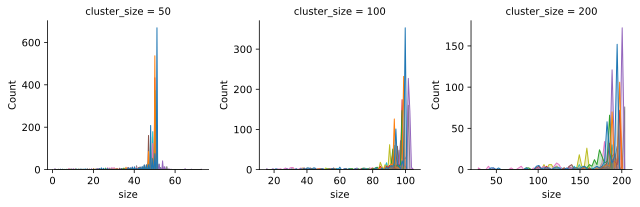

In [22]:
cc_dict = []
for cs in [50,100,200]:
    cc = df[(df.cluster_size==cs)& (df.ratio == 100)].groupby('area').connected_components.sum()
    for a in cc.index:
        for e in cc[a]:
            cc_dict.append({'area': a, 'size':e, 'cluster_size': cs})

fg = sns.FacetGrid(data=pd.DataFrame(cc_dict), col='cluster_size', sharex=False, sharey=False)
fg.map_dataframe(sns.histplot, hue='area', x='size', element="poly", cumulative=False)



**CapEx**

In [23]:
def calc_cost_fiber(g):
    return sum([d['length'] for s,t,d in g.edges(data=True)])*1e-3*capex_costs['fiber_deploy']

def phi(g, n):
    #Find the size of the occupied beam and see how many antennas are needed to cover it.
    thisnode = g.nodes[n]
    beams = []
    for neigh in g[n]:
        thisneigh = g.nodes[neigh]
        beam = m.degrees(m.atan2(thisneigh['x'] - thisnode['x'], thisneigh['y']-thisnode['y'])) % 360
        beams.append(beam)
    beams.sort()
    try:
        beams.append(beams[0])
    except:
        print(g[n])
    beams = np.array(beams)
    
    diff = (beams[1:] - beams[:-1] -0.0001) % 360
    width = 360 - diff.max()    
    return width

def calc_antennas(g, n, gw):
    phi_v = m.ceil(phi(g, n)/mpant_bw)
    n_paths = sum([n['paths'] for n in g[n].values()])
    if not gw:
        #Relay nodes needs double of the BW
        k=2
    else: 
        k=1
    d_v = m.ceil(n_paths*k/contention_ratio)
    return max(phi_v, d_v)

def compute_paths(g, gws):
    for e in g.edges():
        g.edges[e]['paths'] = 0
    
    ## For each edge where a SP pass accumulate a value
    
    paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')
    for k,path in paths.items():
        n_subs = g.nodes(data=True)[k]['subscriptions']
        for i in range(len(path)-1):
            g.edges[path[i], path[i+1]]['paths'] += n_subs
    for e in g.edges():
        if(g.edges[e]['paths'] == 0):
            ## For redundancy link assume a single path
            g.edges[e]['paths'] = 1
            g.edges[e]['redundant'] = 1
        else:
            g.edges[e]['redundant'] = 0
        g.edges[e]['bw'] = mgb * g.edges[e]['paths']
    

def calc_cost_wireless(g) -> list[float]:
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    compute_paths(g, gws)
                 
    ## Multiplicate the value by the BW needed for each node
    ## Calculate the cost of each edge
    

    for n in g.nodes():
        #If it's unconnected it does not cost
        if nx.degree(g)[n] == 0:
            g.nodes[n]['router_cost'] = 0
            g.nodes[n]['deploy'] = 0
            g.nodes[n]['fiber_cost'] = 0
            g.nodes[n]['radio_cost'] = 0
            continue
        #If it's a GW
        if g.nodes[n].get('type') == 'gateway':
            g.nodes[n]['router_cost'] = capex_costs['gateway_router'] 
            #loc = (g.nodes[n]['x'], g.nodes[n]['y'])
            #g.nodes[n]['fiber_cost' ] = capex_costs['fiber_deploy']*road_distance(fiber_points[area], loc)
            g.nodes[n]['deploy'] = capex_costs['gateway_deploy']
            g.nodes[n]['n_ant'] =  calc_antennas(g, n, True)
            #print(g.nodes[n]['n_ant'])
            g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
        else:
            g.nodes[n]['fiber_cost' ] = 0
            if g.degree()[n] == 1:
                #leaf node, no router
                g.nodes[n]['radio_cost'] = capex_costs['leaf_radio']
                g.nodes[n]['deploy'] = capex_costs['leaf_deploy']
                g.nodes[n]['router_cost'] = 0
                g.nodes[n]['n_ant'] = 1
            else:
                #relay node
                g.nodes[n]['n_ant'] = calc_antennas(g, n, False) 
                g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
                g.nodes[n]['deploy'] = capex_costs['relay_deploy']
                g.nodes[n]['router_cost'] = capex_costs['relay_router']
        
        
    router_cost = sum([g.nodes[n]['router_cost'] for n in g.nodes()])
    deploy = sum([g.nodes[n]['deploy'] for n in g.nodes()])
    radio_cost = sum([g.nodes[n]['radio_cost'] for n in g.nodes()])

    return [router_cost, deploy, radio_cost]
  

In [24]:
data = []
data_summed = []
   
for (f,w_g,f_g, n_subs) in graphs:
    graph = w_g.copy()
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    costs = calc_cost_wireless(w_g)
    costs.append(calc_cost_fiber(f_g))
   
    type_costs = ['router_cost', 'deploy', 'radio_cost', 'fiber_cost']
    total_cost = sum(costs)
    data_summed.append({'capex': total_cost/n_subs/5/12,
                        'area': area, 
                        'cluster_size': cluster_size,
                        'ratio':ratio,
                        'n_gw': n_gw})

    for i in range(4):
        measures = {}
        measures['cost'] = costs[i]
        measures['cost_customer'] = costs[i]/n_subs
        measures['5ymontlycostcustomer'] = costs[i]/n_subs/5/12
        measures['type_cost'] = type_costs[i]
        measures['area'] = area
        measures['ratio'] = ratio
        measures['cluster_size'] = cluster_size
        measures['time'] = time
        measures['seed'] = random_seed
        measures['n_gw'] = n_gw

        data.append(measures)
        
edf = pd.DataFrame(data)
sedf = pd.DataFrame(data_summed)

**OpEx**

In [25]:
def calc_opex_fiber_network(g):
    #Fiber opex
    total_bw = sum([d['subscriptions'] for n,d in g.nodes(data=True)])*mgb/1000 #Gbps of mgb
    fiber_transit = m.ceil(total_bw)*opex_costs['bw']
    if total_bw < 10:
        fiber_trasport = opex_costs['transport_10']
    elif total_bw < 100:
        fiber_trasport = opex_costs['transport_100']
    else:
        raise ValueError("Can't relay more than 100G")
    return fiber_transit, fiber_trasport

def calc_opex_maintenance(g, kind):
    #Maintenance opex
    relays = [n for n in g if  g.degree[n] > 1]
    leafs = [n for n in g if  g.degree[n] == 1]
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    p_leaf = len(leafs)/len(g)
    p_relay = len(relays)/len(g)
    p_radio_failure = (364*24)/mttf['radio']
    p_router_failure = (364*24)/mttf['router']

    n_tot_ants = sum([g.nodes[n]['n_ant'] for n in relays])
        
    gw_maintenance = p_router_failure * len(gws) * (mttr['router'] * opex_costs[kind] + capex_costs['gateway_router'])
    router_maintenance = p_router_failure  * len(relays) * (mttr['router'] * opex_costs[kind] + capex_costs['relay_router'])
    leafs_maintenance = p_leaf * p_radio_failure * len(leafs) * (mttr['radio'] * opex_costs['planned_maintenance'] + capex_costs['leaf_radio'])
    relays_maintenance = p_relay * p_radio_failure * n_tot_ants * (mttr['radio'] * opex_costs[kind] + capex_costs['mp_radio'])
    return gw_maintenance + router_maintenance + leafs_maintenance + relays_maintenance
    

In [26]:
data = []
data_summed = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    
    fiber_cost, transport_cost = calc_opex_fiber_network(w_g)
    cost_types = ['fiber', 'planed_maintenance', 'unplanned_maintenance']
    planned_maint = calc_opex_maintenance(w_g, 'planned_maintenance')
    unplanned_maint = calc_opex_maintenance(w_g, 'unplanned_maintenance')

    data.append({'fiber_cost': fiber_cost/n_subs/12,
                 'transport_cost': transport_cost/n_subs/12,
                 'unplanned_cost':  unplanned_maint/n_subs/12,
                 'area': area, 
                 'cluster_size': cluster_size,
                 'ratio':ratio,
                 'n_gw': n_gw})    

    data_summed.append({'cost': planned_maint+fiber_cost, 
                        'cost_customer': (planned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
                        'cost_customer_monthly': (planned_maint+fiber_cost)/n_subs/12,
                        'area': area, 
                        'maintennace': 'planned',
                        'cluster_size': cluster_size,
                        'ratio':ratio,
                        'n_gw': n_gw})

opdf = pd.DataFrame(data)
sopdf = pd.DataFrame(data_summed)

**Offered Bandwidth**

In [27]:
def calc_speed(g, src, dst):
    d = g[src][dst]['dist']
    pl = 20*m.log10(4*m.pi*d/0.0599585) #5ghz
    if g.degree()[dst] == 1: # leaf
        pr = pt + gr_d - pl
    else: #relay
        pr = pt + gr_m - pl
    
    for i in range(len(speed_table)):
        if pr>speed_table[i][0]:
            return speed_table[i][1]
    return 0


def calc_maxbw(g, p):
    bottleneck = speed_table[0][1] #initalize to maximum value (400mbps)
    for i in range(len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        if speed<bottleneck:
            bottleneck=speed
    return bottleneck

def calc_minbw(g, p):
    bw_path = [max_bx*g.nodes[n]['n_ant']/sum([n['paths'] for n in g[n].values()]) for n in p]
    pass
    return min(bw_path)
        
def calc_minbw_leo(g, p):
    bw_path = []
    bw_path.append(max_bx*g.nodes[p[0]]['n_ant']/sum([n['paths'] for n in g[p[0]].values()]))
    for i in range(0, len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        links = g[p[i]][p[i+1]]['paths']
        bw_path.append(speed/links)
    pass
    return min(bw_path)

def calc_minbw_gab(g, path):
    return min([g.nodes[p]['bottleneck'] for p in path])


def compute_bw(g):
    speeds = []
    for n in w_g.nodes():
        if w_g.degree()[n]>0:
            caps = []
            n_paths = 0
            for neigh in w_g[n].keys():
                caps.append(calc_speed(w_g, n, neigh))
                n_paths += w_g[n][neigh]['paths']
            w_g.nodes[n]['capacity'] = w_g.nodes[n]['n_ant'] * np.mean(caps)
            w_g.nodes[n]['paths'] = n_paths
            w_g.nodes[n]['bottleneck'] = w_g.nodes[n]['capacity'] / n_paths

    
    for src, p in paths.items():
        if src in gws:
            continue
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(w_g, p)
        max_bw = calc_maxbw(w_g, p)
        for s in range(w_g.nodes(data=True)[src]['subscriptions']):
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            run['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
            run['n_gw'] = n_gw
            run['node'] = src
            #run['min_bw'] = mac_efficiency*min_bw
            run['max_bw'] = mac_efficiency*max_bw
            run['min_bw'] = mac_efficiency*min_bw
            data.append(run)
        

Minimum bw

In [28]:
mac_efficiency = 0.84

data = []
for g_id, (f,w_g,f_g, n_subs) in enumerate(graphs):
    #print(g_id, len(graphs))
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(w_g, gws, weight='dist')
    speeds = []
    for n in w_g.nodes():
        if w_g.degree()[n]>0:
            caps = []
            n_paths = 0
            for neigh in w_g[n].keys():
                caps.append(calc_speed(w_g, n, neigh))
                n_paths += w_g[n][neigh]['paths']
            w_g.nodes[n]['capacity'] = w_g.nodes[n]['n_ant'] * np.mean(caps)
            w_g.nodes[n]['paths'] = n_paths
            w_g.nodes[n]['bottleneck'] = w_g.nodes[n]['capacity'] / n_paths

    
    for src, p in paths.items():
        if src in gws:
            continue
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(w_g, p)
        
        max_bw = calc_maxbw(w_g, p)
        for s in range(w_g.nodes(data=True)[src]['subscriptions']):
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            run['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
            run['n_gw'] = n_gw
            run['node'] = src
            #run['min_bw'] = mac_efficiency*min_bw
            run['max_bw'] = mac_efficiency*max_bw
            run['min_bw'] = mac_efficiency*min_bw
            data.append(run)

bwdf = pd.DataFrame(data)

Connectivity over failed gateways

In [157]:
data = []
results = []
for g_id, (f, w_g, f_g, n_subs) in enumerate(graphs[:]):

    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    nodes_df = pd.DataFrame([d[1] for d in w_g.nodes(data=True)]).set_index('id')
    gws = list(map(str, nodes_df[nodes_df.type == 'gateway'].index.values))
    clusters = nodes_df.cluster.unique()
    for r in range(10):
        rnd_gws = sorted(gws, key=lambda x:random.random())
        g : nx.Graph = w_g.copy()
        for fails in range(0,5):
            connected = 0
            if fails > 0  and rnd_gws:
                fail_gw = rnd_gws.pop()
                g.remove_node(fail_gw)        
            if rnd_gws:
                paths = nx.multi_source_dijkstra_path_length(g, rnd_gws)
                connected = sum([g.nodes[p]['subscriptions'] for p in paths.keys()])
                all_sums = sum([g.nodes[n]['subscriptions'] for n in g.nodes()])
                
            base_dict = {'area': area, 
                            'ratio': ratio, 
                            'cluster_size': cluster_size, 
                            'n_gw': int(n_gw), 
                            'failed': str(fails)}
            results.append(base_dict | {'connected': connected, 'conn_ratio': connected/all_sums, 'tot_gws': len(rnd_gws), 'all_sums': all_sums})


con_fw_df = pd.DataFrame(results)


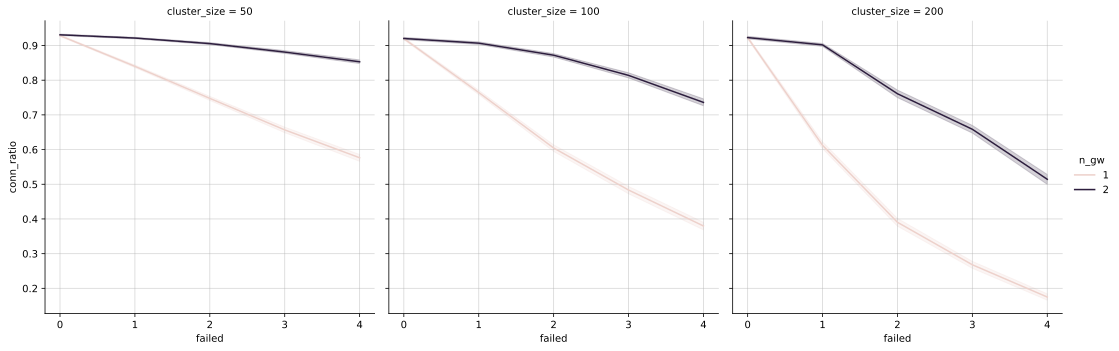

In [167]:
g = sns.relplot(data=con_fw_df, x='failed', y='conn_ratio', col='cluster_size', hue='n_gw', kind='line')#markers='o', style='failed')
for ax in g.axes.flatten():
    ax.grid(alpha=0.5)
    #ax.set_ylim([0.9,1.0])

minimum bandwidth over failed gws

In [ ]:
mac_efficiency = 0.84

def calc_speeds(graph, gws):
    g = graph.copy()
    results = []
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')
    #print(gws, len(paths), sorted(paths.items()))
    speeds = []
    for n in g.nodes():
        if g.degree()[n]>0:
            caps = []
            n_paths = 0
            for neigh in g[n].keys():
                caps.append(calc_speed(g, n, neigh))
                n_paths += g[n][neigh]['paths']
            g.nodes[n]['capacity'] = g.nodes[n]['n_ant'] * np.mean(caps)
            #print(f"{g.nodes[n].get('paths', 0)} {n_paths}")
            g.nodes[n]['paths'] = n_paths
            g.nodes[n]['bottleneck'] = g.nodes[n]['capacity'] / n_paths

    for src, p in paths.items():
        if src in gws:
            continue
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(g, p)
        max_bw = calc_maxbw(g, p)
        for s in range(g.nodes(data=True)[src]['subscriptions']):
            results.append({'min_bw': mac_efficiency*min_bw, 'max_bw': mac_efficiency*max_bw})
    return results

data = []
results = []
results_nodes = []
for g_id, (f, w_g, f_g, n_subs) in enumerate(graphs[:]):
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    if n_gw == '1':
        #it's useless to compute the bw with only 1 gw
        continue
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    nodes_df = pd.DataFrame([d[1] for d in w_g.nodes(data=True)]).set_index('id')
    clusters = nodes_df.cluster.unique()
    for c in clusters:
        nodes_c = nodes_df[nodes_df.cluster == c]
        g_c = nx.subgraph(w_g, map(str, nodes_c.index.values))
        gw_c = nodes_c[nodes_c.type == 'gateway'].index.values
        speeds =  calc_speeds(g_c, list(map(str,gw_c)))
        avg_min = np.mean([s['min_bw'] for s in speeds])
        base_dict = {'area': area, 
                        'ratio': ratio, 
                        'cluster_size': cluster_size, 
                        'n_gw': int(n_gw),
                        'failed': '0',
                        'nodes': len(g_c),
                        'cluster': c                    
                    }
        for s in speeds:
                results_nodes.append(s | base_dict)
        if len(gw_c) == 1:
            continue #weird corner case with only 1GW
        for gw_i in range(2):
            dead_gw = str(gw_c[gw_i])
            alive_gw = str(gw_c[int(not gw_i)])
            g_c = nx.subgraph(w_g, map(str, nodes_c.index.values)).copy()
            g_c.remove_node(dead_gw)
            #recompute the paths passing through the edges
            compute_paths(g_c, [alive_gw])
            #compute speeds
            speeds =  calc_speeds(g_c, [alive_gw])
            avg_min = np.mean([s['min_bw'] for s in speeds])
            base_dict = {'area': area, 
                         'ratio': ratio, 
                         'cluster_size': cluster_size, 
                         'n_gw': int(n_gw),
                         'failed': '1',
                         'nodes': len(g_c),
                         'cluster': c
                        }
            for s in speeds:
                results_nodes.append(s | base_dict)    

bw_fail_gw = pd.DataFrame(results_nodes)

In [36]:
fail_bw = bw_fail_gw[(bw_fail_gw.cluster_size==200) & (bw_fail_gw.failed == '1')].groupby(['ratio'])['min_bw'].agg(['mean', ci])
to_csv_comment(fail_bw, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/min_bw_fail.csv')
print(fail_bw)

           mean        ci
ratio                    
25     4.941463  0.022061
50     4.833568  0.016275
100    4.650394  0.009471


In [37]:
fail_bw = fail_gw[(fail_gw.cluster_size==200) & (fail_gw.failed == '1')].groupby(['ratio'])['max_bw'].agg(['mean', ci])
to_csv_comment(fail_bw, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/max_bw_fail.csv')
print(fail_bw)

             mean        ci
ratio                      
25     332.358290  0.104886
50     333.690926  0.055657
100    333.183602  0.049705


Link resiliency

In [160]:

results = []
for g_id, (f, w_g, f_g, n_subs) in enumerate(graphs[:]):

    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    nodes_df = pd.DataFrame([d[1] for d in w_g.nodes(data=True)]).set_index('id')
    gws = list(map(str, nodes_df[nodes_df.type == 'gateway'].index.values))
    for r in range(10):
        g : nx.Graph = w_g.copy()
        for fails in range(0,10):
            connected = 0
            if fails>0 and len(g.edges()): #with 0 fails we don't want to remove any node
                to_rem = [random.choice(list(g.edges()))]
                g.remove_edges_from(to_rem)
            paths = nx.multi_source_dijkstra_path_length(g, gws)
            connected = sum([g.nodes[p]['subscriptions'] for p in paths.keys()])
            all_sums = sum([g.nodes[n]['subscriptions'] for n in g.nodes()])
            
            base_dict = {'area': area, 
                            'ratio': ratio, 
                            'cluster_size': cluster_size, 
                            'n_gw': int(n_gw), 
                            'failed': str(fails)}
            #print(fails, connected, all_sums)
            results.append(base_dict | {'connected': connected, 'conn_ratio': connected/all_sums, 'tot_gws': len(rnd_gws), 'all_sums': all_sums})
        del g

linkres_df = pd.DataFrame(results)


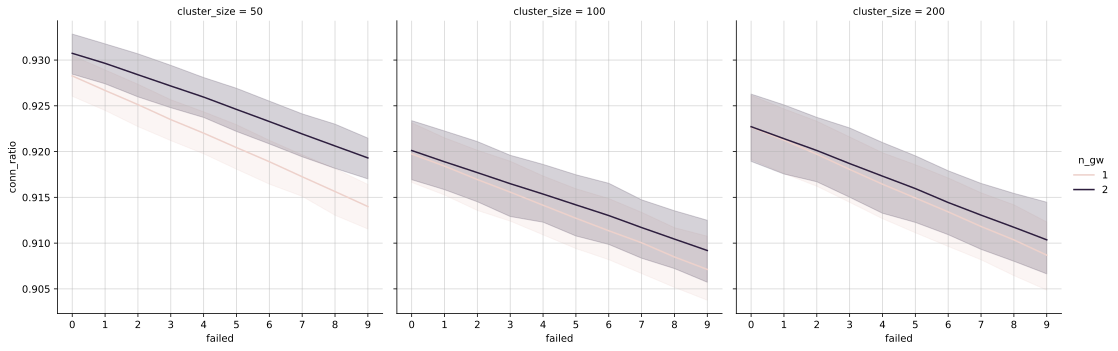

In [166]:
g = sns.relplot(data=linkres_df, x='failed',y='conn_ratio', col='cluster_size', kind='line', hue='n_gw')#, style='failed', markers=True)
for ax in g.axes.flatten():
    ax.grid(alpha=0.5)
    #ax.set_ylim([0.9,1.0])

Antenna resiliency per network (stuck in while lookp)

In [ ]:
mac_efficiency = 0.84
from tqdm import tqdm

data = []
results = []
results_nodes = []
for g_id, (f, w_g, f_g, n_subs) in enumerate(graphs[:]):

    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    nodes_df = pd.DataFrame([d[1] for d in w_g.nodes(data=True)]).set_index('id')
    clusters = nodes_df.cluster.unique()
    for r in range(10):
        g : nx.Graph = w_g.copy()
        gws = list(map(str, nodes_df[nodes_df.type == 'gateway'].index.values))
        for fails in range(0,10):
            connected = 0
            if fails>0: #with 0 fails we don't want to remove any node
                n,d = random.choice(list(g.nodes(data=True)))
                while(g.degree(n) == 0 or d.get('n_ant', 0) == 0): #if i pick up an unconnected node, retry
                    n,d = random.choice(list(g.nodes(data=True)))
                edges_per_ant = len(g[n])/d['n_ant']
                edges_to_kill = round(edges_per_ant+random.random()-0.5)
                to_rem = [(n, tgt) for tgt in random.sample(list(nx.neighbors(g, n)), k=edges_to_kill)]
                g.remove_edges_from(to_rem)
                g.nodes[n]['n_ant'] -= 1
                #if(g.nodes[n]['n_ant'] == 0):
                    #if n in gws:
                        #gws.remove(n)
                        #print(f"removed {n}")
            paths = nx.multi_source_dijkstra_path_length(g, gws)
            connected = sum([g.nodes[p]['subscriptions'] for p in paths.keys()])
            all_sums = sum([g.nodes[n]['subscriptions'] for n in g.nodes()])
            
            base_dict = {'area': area, 
                        'ratio': ratio, 
                        'cluster_size': cluster_size, 
                        'n_gw': int(n_gw), 
                        'failed': str(fails),
                        'edges': len(g.edges())}
            results.append(base_dict | {'connected': connected, 'conn_ratio': connected/all_sums, 'tot_gws': len(gws), 'all_sums': all_sums})

antres_df = pd.DataFrame(results)


In [ ]:
g = sns.relplot(data=antres_df, x='failed',y='conn_ratio', col='cluster_size', kind='line', hue='n_gw')
for ax in g.axes.flatten():
    ax.grid(alpha=0.5) 

Antenna resiliency per cluster

In [169]:
mac_efficiency = 0.84
from tqdm import tqdm

data = []
results = []
results_nodes = []
for g_id, (f, w_g, f_g, n_subs) in enumerate(graphs[:]):
    #for each simulated network
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    nodes_df = pd.DataFrame([d[1] for d in w_g.nodes(data=True)]).set_index('id')
    clusters = nodes_df.cluster.unique()
    for c in clusters:
        #for each cluster
        nodes_c = nodes_df[nodes_df.cluster == c]
        g_c = nx.subgraph(w_g, map(str, nodes_c.index.values))
        gw_c = nodes_c[nodes_c.type == 'gateway'].index.values
        for r in range(10):
            #10 iid runs
            g : nx.Graph = g_c.copy()
            gws = list(map(str, gw_c))
            for fails in range(10):
                connected = 0
                if fails>0: #with 0 fails we don't want to remove any node
                    n,d = random.choice(list(g.nodes(data=True)))
                    i=0
                    while(g.degree(n) < 2 or d.get('n_ant', 0) == 0): #if i pick up an unconnected node, retry
                        n,d = random.choice(list(g.nodes(data=True)))    
                        i+=1
                        if i == 50:
                            break
                    if d.get('n_ant',0) == 0:
                        continue
                    edges_per_ant = len(g[n])/d['n_ant']
                    edges_to_kill = round(edges_per_ant+random.random()-0.5)
                    to_rem = [(n, tgt) for tgt in random.sample(list(nx.neighbors(g, n)), k=edges_to_kill)]
                    g.remove_edges_from(to_rem)
                    g.nodes[n]['n_ant'] -= 1
                paths = nx.multi_source_dijkstra_path_length(g, gws)
                connected = sum([g.nodes[p]['subscriptions'] for p in paths.keys()])
                all_sums = sum([g.nodes[n]['subscriptions'] for n in g.nodes()])
                base_dict = {'area': area, 
                            'ratio': ratio, 
                            'cluster_size': cluster_size, 
                            'n_gw': int(n_gw), 
                            'failed': str(fails),
                            'edges': len(g.edges())}
                results.append(base_dict | {'connected': connected, 'conn_ratio': connected/all_sums, 'tot_gws': len(gws), 'all_sums': all_sums})

antres_custer_df = pd.DataFrame(results)


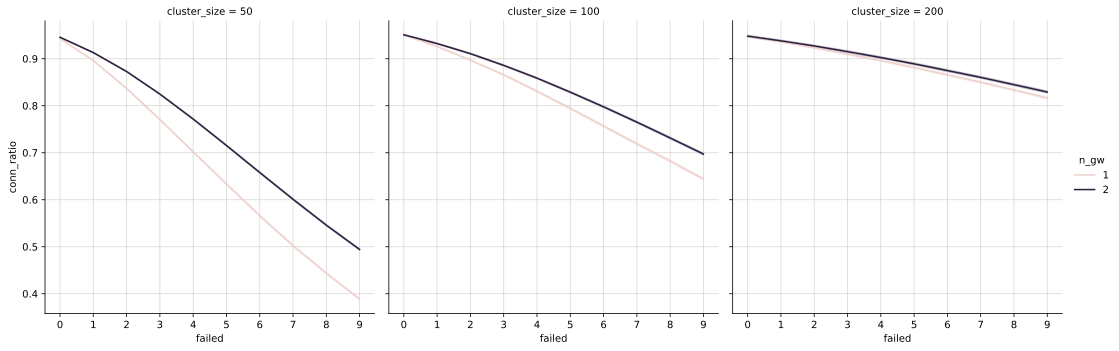

In [173]:
g = sns.relplot(data=antres_custer_df, x='failed',y='conn_ratio', col='cluster_size', kind='line', hue='n_gw')
for ax in g.axes.flatten():
    ax.grid(alpha=0.5) 

**Antennas per node**

In [174]:

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, n_gw, time, random_seed = re.split('[._/]', f)[1:7]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    
    for n in w_g.nodes():
        if w_g.degree()[n] > 0:
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            if n in gws:
                run['type'] = 'gw'
            elif w_g.degree()[n]==1:
                run['type'] = 'leaf'
            else:
                run['type'] = 'relay'
            run['antennae'] =  w_g.nodes[n]['n_ant']
            run['degree'] = w_g.degree()[n]
            run['n_gw'] = n_gw
            data.append(run)
            

ant_node = pd.DataFrame(data)

**Gnuplot Graphs**

Fiber deploy over cluster size and customer ratio

In [175]:
for n_gw in ['1','2']:
    fiber = edf[(edf.type_cost=='fiber_cost') & (edf.n_gw == n_gw)]
    data = fiber.groupby(['ratio', 'cluster_size'])['cost_customer'].agg(['mean', ci])
    data = data.reset_index().pivot('cluster_size', 'ratio',['mean', 'ci'])
    data.columns = ["_".join([a[0], str(a[1])]) for a in data.columns.to_flat_index()]
    to_csv_comment(data, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/fiber_cost_{n_gw}.csv')
#sns.relplot(data=data, x='gateways', y='mean', hue='ratio', kind='line')


/tmp/ipykernel_2001219/248725921.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.reset_index().pivot('cluster_size', 'ratio',['mean', 'ci'])
/tmp/ipykernel_2001219/248725921.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.reset_index().pivot('cluster_size', 'ratio',['mean', 'ci'])


Overall cost for cluster = 200 over customer ratio

In [176]:
for n_gw in ['1','2']:
    costs = opdf[(opdf.cluster_size==200)& (opdf.n_gw == n_gw)].groupby('ratio')[['fiber_cost', 'transport_cost', 'unplanned_cost']].agg(['mean', ci])
    capex = sedf[(sedf.cluster_size==200)& (sedf.n_gw == n_gw)].groupby('ratio')['capex'].agg(['mean', ci])
    costs['capex', 'mean'] = capex['mean']
    costs['capex', 'ci'] = capex['ci']
    costs.columns = ["_".join(a) for a in costs.columns.to_flat_index()]
    costs['recurring'] = costs['fiber_cost_mean'] + costs['transport_cost_mean'] + costs['unplanned_cost_mean']
    costs['sum'] = costs['recurring'] + costs['capex_mean']

    costs.index = costs.index/100
    to_csv_comment(costs, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/costs_{n_gw}.csv')


Capex customer breaked up

In [177]:
for n_gw in ['1','2']:
    rat = df[(df.cluster_size == 200) & (df.n_gw == n_gw)].groupby(['ratio'])['relays_ratio'].agg(['mean', ci])
    capex1 = edf[(edf.cluster_size==200) & (edf.n_gw == n_gw)].groupby(['ratio', 'type_cost'])['cost_customer'].agg(['mean', ci])
    capex =  capex1.reset_index().pivot('ratio', 'type_cost',['mean', 'ci'])
    capex.columns = ["_".join(a) for a in capex.columns.to_flat_index()]
    capex['relayratio_mean'] = rat['mean']
    capex['relayratio_ci'] = rat.ci
    capex['sum'] = capex['mean_deploy'] + capex['mean_fiber_cost'] + capex['mean_radio_cost'] + capex['mean_router_cost']

    capex.index = capex.index/100
    to_csv_comment(capex, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/capex_{n_gw}.csv')


/tmp/ipykernel_2001219/1334557379.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  capex =  capex1.reset_index().pivot('ratio', 'type_cost',['mean', 'ci'])
/tmp/ipykernel_2001219/1334557379.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  capex =  capex1.reset_index().pivot('ratio', 'type_cost',['mean', 'ci'])


Effective bandwidth

In [178]:
for n_gw in ['1', '2']:
    min_bw = bwdf[(bwdf.cluster_size==200) & (bwdf.n_gw == n_gw)].groupby(['ratio'])['min_bw'].agg(['mean', ci])
    to_csv_comment(min_bw, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/min_bw_{n_gw}.csv')
    print(min_bw)
#sns.relplot(data=bwdf, x='gateways', y='min_bw', hue='ratio', kind='line')

           mean        ci
ratio                    
25     7.860257  0.015092
50     7.688463  0.009803
100    7.372655  0.004097
            mean        ci
ratio                     
25     11.469755  0.071216
50     11.221860  0.049566
100    10.363664  0.029553


In [179]:
for n_gw in ['1', '2']:
    max_bw = bwdf[(bwdf.cluster_size==200) & (bwdf.n_gw == n_gw)].groupby(['ratio'])['max_bw'].agg(['mean', ci])
    max_bw.index = max_bw.index/100
    to_csv_comment(max_bw, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/max_bw_{n_gw}.csv')

In [ ]:
pd.concat([capex['sum'],  costs['recurring'], costs['sum'], min_bw['mean'], costs['sum']/min_bw['mean'],max_bw['mean'], costs['sum']/max_bw['mean']], axis=1)

,sum,recurring,sum,mean,0,mean,1
ratio,,,,,,,
0.25,1364.028107,16.160753,38.894555,NaN,NaN,335.577705,0.115903
0.50,1104.573199,10.305767,28.715321,NaN,NaN,335.657932,0.085549
1.00,859.529443,7.028066,21.353557,NaN,NaN,335.850654,0.063581
25.00,NaN,NaN,NaN,11.492705,NaN,NaN,NaN
50.00,NaN,NaN,NaN,11.216644,NaN,NaN,NaN
100.00,NaN,NaN,NaN,10.366557,NaN,NaN,NaN


In [180]:
for n_gw in ['1', '2']:
    ant_type = ant_node[(ant_node.cluster_size == 200) &(ant_node.type != 'leaf')&(ant_node.ratio!=20)& (ant_node.n_gw == n_gw)][['antennae', 'type']]
    to_csv_comment(ant_type, f'/home/gabriel/WORKS/TrueNets/CNSM22/processed/ant_type_{n_gw}.csv')